In [1]:
import medmnist
from medmnist import INFO
from medmnist.dataset import BreastMNIST
from torchvision import transforms


In [2]:
# Charger les infos sur le dataset
data_flag = 'breastmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist.dataset, info['python_class'])
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # convertit (1, 28, 28) → (3, 28, 28)
])

# Charger le dataset
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset  = DataClass(split='test', transform=data_transform, download=download)
val_dataset   = DataClass(split='val', transform=data_transform, download=download)


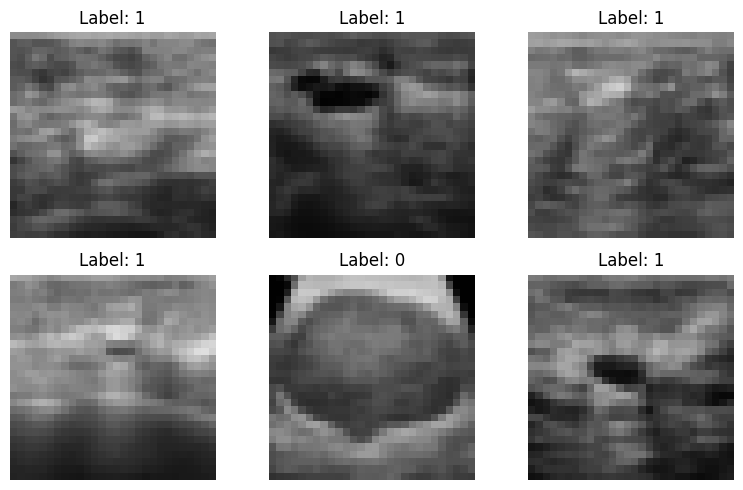

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(8, 5))
for i in range(6):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0)  # (C, H, W) → (H, W, C)

    axes[i//3, i%3].imshow(img, cmap='gray')
    axes[i//3, i%3].set_title(f"Label: {label.item()}")
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()



In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models


In [6]:
# Charger le modèle ResNet18 pré-entraîné
resnet18 = models.resnet18(pretrained=True)

# On remplace la dernière couche (fc) par une couche pour 1 sortie (sigmoid pour binaire)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)


c:\Users\sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
for param in resnet18.parameters():
    param.requires_grad = False

# Débloquer la dernière couche (fc)
for param in resnet18.fc.parameters():
    param.requires_grad = True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)


NameError: name 'model' is not defined

In [9]:
import torch.optim as optim

criterion = nn.BCELoss()  # car sortie avec Sigmoid et binaire
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)


In [14]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            images = images.to(device)
            targets = targets.to(device).float()
            targets = targets.view(-1, 1)  # reshape: (batch_size,) → (batch_size, 1)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                images = images.to(device)
                targets = targets.to(device).float()
                targets = targets.view(-1, 1)  # reshape again

                outputs = model(images)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * images.size(0)

                preds = (outputs > 0.5).float()
                correct += (preds == targets).sum().item()
                total += targets.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        acc = correct / total

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")


In [15]:
train_model(
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=5
)



Epoch 1/5 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch 1 | Train Loss: 0.6183 | Val Loss: 0.6191 | Val Acc: 0.7308


Epoch 2/5 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


Epoch 2 | Train Loss: 0.5982 | Val Loss: 0.6037 | Val Acc: 0.7308


Epoch 3/5 - Val: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch 3 | Train Loss: 0.5427 | Val Loss: 0.5850 | Val Acc: 0.7308


Epoch 4/5 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


Epoch 4 | Train Loss: 0.5306 | Val Loss: 0.5855 | Val Acc: 0.7308


Epoch 5/5 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

Epoch 5 | Train Loss: 0.5211 | Val Loss: 0.5421 | Val Acc: 0.7308


In [19]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)
print("sys.path[0] =", sys.path[0])
# Sauvegarde
torch.save(resnet18.state_dict(), 'C:/Users/sarah/Documents/projects/python/breast_cancer_detection/models/ResNet18_model_model.pt')
print("Modèle multimodal sauvé dans models/ ResNet18_model.pt")

sys.path[0] = c:\Users\sarah\Documents\projects\python\breast_cancer_detection
Modèle multimodal sauvé dans models/ ResNet18_model.pt


In [35]:
import os
import matplotlib.pyplot as plt

# Crée un dossier pour stocker les images de test
os.makedirs('test_images', exist_ok=True)

# Sauvegarde les 10 premières images
for i in range(10):
    img, label = train_dataset[i]            # train_dataset = BreastMNIST(...)
    # img : Tensor (3,28,28) après transform(), on convertit en (H,W) pour grayscale
    gray = img[0].cpu().numpy()              # choix du premier canal
    path = f'test_images/img_{i}_lbl{int(label)}.png'
    plt.imsave(path, gray, cmap='gray')
    print(f"Saved {path}")


Saved test_images/img_0_lbl1.png
Saved test_images/img_1_lbl1.png
Saved test_images/img_2_lbl1.png
Saved test_images/img_3_lbl1.png
Saved test_images/img_4_lbl0.png
Saved test_images/img_5_lbl1.png
Saved test_images/img_6_lbl1.png
Saved test_images/img_7_lbl1.png
Saved test_images/img_8_lbl0.png
Saved test_images/img_9_lbl1.png


C:\Users\sarah\AppData\Local\Temp\ipykernel_18516\1736721687.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  path = f'test_images/img_{i}_lbl{int(label)}.png'
